## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-09-02 17:49:51--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  61.2MB/s    in 5.1s    

2020-09-02 17:49:57 (62.9 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()

if torch.cuda.is_available():  
      dev = "cuda:0" 
else:  
      dev = "cpu"  
device = torch.device(dev)

net.to(device)

print(net)

Net(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(56, 84, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(84, 112, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(112, 140, kernel_size=(5

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        if torch.cuda.is_available():  
              dev = "cuda:0" 
        else:  
              dev = "cpu"  
        device = torch.device(dev)
        

        # forward pass to get net output
        output_pts = net(images.to(device))
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

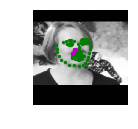

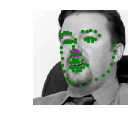

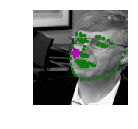

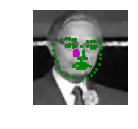

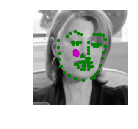

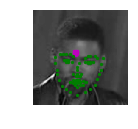

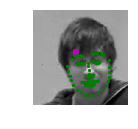

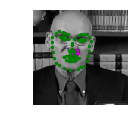

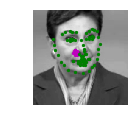

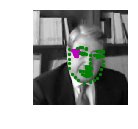

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.to('cpu').numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [20]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion =  nn.SmoothL1Loss() # https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7


optimizer = optim.Adam(net.parameters(), lr = 0.001) #https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [22]:
def train_net(n_epochs):
    if torch.cuda.is_available():  
          dev = "cuda:0" 
    else:  
          dev = "cpu"  
    device = torch.device(dev)

    # prepare the net for training
    net.to(device)
    net.train()
    

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            
            output_pts = net(images.to(device))

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts.to('cpu'), key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [23]:
# train your network
n_epochs = 40 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.16968167796730996
Epoch: 1, Batch: 20, Avg. Loss: 0.10816127881407737
Epoch: 1, Batch: 30, Avg. Loss: 0.11665731742978096
Epoch: 1, Batch: 40, Avg. Loss: 0.1204206645488739
Epoch: 1, Batch: 50, Avg. Loss: 0.10550146661698818
Epoch: 1, Batch: 60, Avg. Loss: 0.0933345291763544
Epoch: 1, Batch: 70, Avg. Loss: 0.09130350798368454
Epoch: 1, Batch: 80, Avg. Loss: 0.09643444493412971
Epoch: 1, Batch: 90, Avg. Loss: 0.11943259686231614
Epoch: 1, Batch: 100, Avg. Loss: 0.12073112055659294
Epoch: 1, Batch: 110, Avg. Loss: 0.0882071677595377
Epoch: 1, Batch: 120, Avg. Loss: 0.08471852838993073
Epoch: 1, Batch: 130, Avg. Loss: 0.07355204708874226
Epoch: 1, Batch: 140, Avg. Loss: 0.0721471767872572
Epoch: 1, Batch: 150, Avg. Loss: 0.0684370320290327
Epoch: 1, Batch: 160, Avg. Loss: 0.0778183475136757
Epoch: 1, Batch: 170, Avg. Loss: 0.08097096607089042
Epoch: 1, Batch: 180, Avg. Loss: 0.090775403752923
Epoch: 1, Batch: 190, Avg. Loss: 0.06946291141211987
Epoch: 1, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.044396393746137616
Epoch: 2, Batch: 20, Avg. Loss: 0.03615512792021036
Epoch: 2, Batch: 30, Avg. Loss: 0.0470041086897254
Epoch: 2, Batch: 40, Avg. Loss: 0.0561783641576767
Epoch: 2, Batch: 50, Avg. Loss: 0.059425785578787325
Epoch: 2, Batch: 60, Avg. Loss: 0.05106005929410458
Epoch: 2, Batch: 70, Avg. Loss: 0.05088636111468077
Epoch: 2, Batch: 80, Avg. Loss: 0.05215552374720574
Epoch: 2, Batch: 90, Avg. Loss: 0.041039923392236236
Epoch: 2, Batch: 100, Avg. Loss: 0.03413043990731239
Epoch: 2, Batch: 110, Avg. Loss: 0.046076131612062456
Epoch: 2, Batch: 120, Avg. Loss: 0.027023165579885246
Epoch: 2, Batch: 130, Avg. Loss: 0.05213615018874407
Epoch: 2, Batch: 140, Avg. Loss: 0.04811031371355057
Epoch: 2, Batch: 150, Avg. Loss: 0.07411739937961101
Epoch: 2, Batch: 160, Avg. Loss: 0.030897825956344604
Epoch: 2, Batch: 170, Avg. Loss: 0.044248552061617374
Epoch: 2, Batch: 180, Avg. Loss: 0.05033032540231943
Epoch: 2, Batch: 190, Avg. Loss: 0.032845837064087

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.03435001606121659
Epoch: 3, Batch: 20, Avg. Loss: 0.0333527036011219
Epoch: 3, Batch: 30, Avg. Loss: 0.0317656371742487
Epoch: 3, Batch: 40, Avg. Loss: 0.07630684655159711
Epoch: 3, Batch: 50, Avg. Loss: 0.03457965347915888
Epoch: 3, Batch: 60, Avg. Loss: 0.044514978490769866
Epoch: 3, Batch: 70, Avg. Loss: 0.03233140856027603
Epoch: 3, Batch: 80, Avg. Loss: 0.04503879118710756
Epoch: 3, Batch: 90, Avg. Loss: 0.03832559529691935
Epoch: 3, Batch: 100, Avg. Loss: 0.026328803692013025
Epoch: 3, Batch: 110, Avg. Loss: 0.023978894110769033
Epoch: 3, Batch: 120, Avg. Loss: 0.03307358473539353
Epoch: 3, Batch: 130, Avg. Loss: 0.031002573668956757
Epoch: 3, Batch: 140, Avg. Loss: 0.022799941711127758
Epoch: 3, Batch: 150, Avg. Loss: 0.04250008091330528
Epoch: 3, Batch: 160, Avg. Loss: 0.027593094017356636
Epoch: 3, Batch: 170, Avg. Loss: 0.039657014049589635
Epoch: 3, Batch: 180, Avg. Loss: 0.048954783193767074
Epoch: 3, Batch: 190, Avg. Loss: 0.04472868219017

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.02464093631133437
Epoch: 4, Batch: 20, Avg. Loss: 0.022528254240751267
Epoch: 4, Batch: 30, Avg. Loss: 0.028421839606016873
Epoch: 4, Batch: 40, Avg. Loss: 0.03126319572329521
Epoch: 4, Batch: 50, Avg. Loss: 0.01842803480103612
Epoch: 4, Batch: 60, Avg. Loss: 0.018760980013757943
Epoch: 4, Batch: 70, Avg. Loss: 0.030487748607993127
Epoch: 4, Batch: 80, Avg. Loss: 0.019967644475400448
Epoch: 4, Batch: 90, Avg. Loss: 0.02051159683614969
Epoch: 4, Batch: 100, Avg. Loss: 0.03572483630850911
Epoch: 4, Batch: 110, Avg. Loss: 0.03397705499082804
Epoch: 4, Batch: 120, Avg. Loss: 0.02853152686730027
Epoch: 4, Batch: 130, Avg. Loss: 0.03702098689973354
Epoch: 4, Batch: 140, Avg. Loss: 0.03047466538846493
Epoch: 4, Batch: 150, Avg. Loss: 0.025193871557712556
Epoch: 4, Batch: 160, Avg. Loss: 0.036283120326697824
Epoch: 4, Batch: 170, Avg. Loss: 0.03818652629852295
Epoch: 4, Batch: 180, Avg. Loss: 0.02000492587685585
Epoch: 4, Batch: 190, Avg. Loss: 0.0430962977930

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.019271144270896913
Epoch: 5, Batch: 20, Avg. Loss: 0.02091852892190218
Epoch: 5, Batch: 30, Avg. Loss: 0.026195190008729698
Epoch: 5, Batch: 40, Avg. Loss: 0.022060070652514696
Epoch: 5, Batch: 50, Avg. Loss: 0.024820731952786446
Epoch: 5, Batch: 60, Avg. Loss: 0.021035140473395587
Epoch: 5, Batch: 70, Avg. Loss: 0.026497881021350624
Epoch: 5, Batch: 80, Avg. Loss: 0.02194638308137655
Epoch: 5, Batch: 90, Avg. Loss: 0.018571244552731514
Epoch: 5, Batch: 100, Avg. Loss: 0.024564462434500455
Epoch: 5, Batch: 110, Avg. Loss: 0.02737685842439532
Epoch: 5, Batch: 120, Avg. Loss: 0.026476875226944686
Epoch: 5, Batch: 130, Avg. Loss: 0.018750809691846372
Epoch: 5, Batch: 140, Avg. Loss: 0.02885655201971531
Epoch: 5, Batch: 150, Avg. Loss: 0.025242965389043092
Epoch: 5, Batch: 160, Avg. Loss: 0.024519468005746604
Epoch: 5, Batch: 170, Avg. Loss: 0.01839329954236746
Epoch: 5, Batch: 180, Avg. Loss: 0.024000885710120202
Epoch: 5, Batch: 190, Avg. Loss: 0.0382825

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.021541226003319026
Epoch: 6, Batch: 20, Avg. Loss: 0.019159272126853467
Epoch: 6, Batch: 30, Avg. Loss: 0.01940101645886898
Epoch: 6, Batch: 40, Avg. Loss: 0.014544100128114223
Epoch: 6, Batch: 50, Avg. Loss: 0.015290233492851257
Epoch: 6, Batch: 60, Avg. Loss: 0.023889610636979343
Epoch: 6, Batch: 70, Avg. Loss: 0.01867641769349575
Epoch: 6, Batch: 80, Avg. Loss: 0.019115676730871202
Epoch: 6, Batch: 90, Avg. Loss: 0.019809182919561862
Epoch: 6, Batch: 100, Avg. Loss: 0.018525093141943217
Epoch: 6, Batch: 110, Avg. Loss: 0.019480332359671594
Epoch: 6, Batch: 120, Avg. Loss: 0.023339331895112992
Epoch: 6, Batch: 130, Avg. Loss: 0.022030833642929792
Epoch: 6, Batch: 140, Avg. Loss: 0.016728352941572665
Epoch: 6, Batch: 150, Avg. Loss: 0.023559595737606288
Epoch: 6, Batch: 160, Avg. Loss: 0.014115219097584486
Epoch: 6, Batch: 170, Avg. Loss: 0.01990868095308542
Epoch: 6, Batch: 180, Avg. Loss: 0.017025184771046042
Epoch: 6, Batch: 190, Avg. Loss: 0.01969

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.016483891382813455
Epoch: 7, Batch: 20, Avg. Loss: 0.016423161327838897
Epoch: 7, Batch: 30, Avg. Loss: 0.014031588193029165
Epoch: 7, Batch: 40, Avg. Loss: 0.016502447426319122
Epoch: 7, Batch: 50, Avg. Loss: 0.03237451855093241
Epoch: 7, Batch: 60, Avg. Loss: 0.014505560882389546
Epoch: 7, Batch: 70, Avg. Loss: 0.01596125718206167
Epoch: 7, Batch: 80, Avg. Loss: 0.020872365310788156
Epoch: 7, Batch: 90, Avg. Loss: 0.015056658443063498
Epoch: 7, Batch: 100, Avg. Loss: 0.020892619900405408
Epoch: 7, Batch: 110, Avg. Loss: 0.018648909404873848
Epoch: 7, Batch: 120, Avg. Loss: 0.030552083626389503
Epoch: 7, Batch: 130, Avg. Loss: 0.011782255209982394
Epoch: 7, Batch: 140, Avg. Loss: 0.017646590899676084
Epoch: 7, Batch: 150, Avg. Loss: 0.015304358582943678
Epoch: 7, Batch: 160, Avg. Loss: 0.016065400373190642
Epoch: 7, Batch: 170, Avg. Loss: 0.021074653835967183
Epoch: 7, Batch: 180, Avg. Loss: 0.01382554080337286
Epoch: 7, Batch: 190, Avg. Loss: 0.01462

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.024551428202539683
Epoch: 8, Batch: 20, Avg. Loss: 0.01848797807469964
Epoch: 8, Batch: 30, Avg. Loss: 0.02706173751503229
Epoch: 8, Batch: 40, Avg. Loss: 0.016717376932501794
Epoch: 8, Batch: 50, Avg. Loss: 0.016776553355157375
Epoch: 8, Batch: 60, Avg. Loss: 0.01618702937848866
Epoch: 8, Batch: 70, Avg. Loss: 0.01652917582541704
Epoch: 8, Batch: 80, Avg. Loss: 0.044810697250068185
Epoch: 8, Batch: 90, Avg. Loss: 0.01703212782740593
Epoch: 8, Batch: 100, Avg. Loss: 0.04114075135439634
Epoch: 8, Batch: 110, Avg. Loss: 0.018857941124588253
Epoch: 8, Batch: 120, Avg. Loss: 0.02933604447171092
Epoch: 8, Batch: 130, Avg. Loss: 0.02746907910332084
Epoch: 8, Batch: 140, Avg. Loss: 0.024141559656709433
Epoch: 8, Batch: 150, Avg. Loss: 0.015517599880695343
Epoch: 8, Batch: 160, Avg. Loss: 0.017306257411837576
Epoch: 8, Batch: 170, Avg. Loss: 0.01774377692490816
Epoch: 8, Batch: 180, Avg. Loss: 0.014758755080401897
Epoch: 8, Batch: 190, Avg. Loss: 0.01764363255

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.015887884330004452
Epoch: 9, Batch: 20, Avg. Loss: 0.015071314293891191
Epoch: 9, Batch: 30, Avg. Loss: 0.033794183656573294
Epoch: 9, Batch: 40, Avg. Loss: 0.01979607418179512
Epoch: 9, Batch: 50, Avg. Loss: 0.016618616320192812
Epoch: 9, Batch: 60, Avg. Loss: 0.014407286141067743
Epoch: 9, Batch: 70, Avg. Loss: 0.014797377120703458
Epoch: 9, Batch: 80, Avg. Loss: 0.021730232611298562
Epoch: 9, Batch: 90, Avg. Loss: 0.017548794392496347
Epoch: 9, Batch: 100, Avg. Loss: 0.01862003719434142
Epoch: 9, Batch: 110, Avg. Loss: 0.020532838255167007
Epoch: 9, Batch: 120, Avg. Loss: 0.029219455923885106
Epoch: 9, Batch: 130, Avg. Loss: 0.021098471339792015
Epoch: 9, Batch: 140, Avg. Loss: 0.01780296666547656
Epoch: 9, Batch: 150, Avg. Loss: 0.014845861494541169
Epoch: 9, Batch: 160, Avg. Loss: 0.013759576436132192
Epoch: 9, Batch: 170, Avg. Loss: 0.015917263086885215
Epoch: 9, Batch: 180, Avg. Loss: 0.030524023715406655
Epoch: 9, Batch: 190, Avg. Loss: 0.01680

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.01750603299587965
Epoch: 10, Batch: 20, Avg. Loss: 0.016096323635429143
Epoch: 10, Batch: 30, Avg. Loss: 0.015359136741608381
Epoch: 10, Batch: 40, Avg. Loss: 0.024276120774447917
Epoch: 10, Batch: 50, Avg. Loss: 0.03390321005135775
Epoch: 10, Batch: 60, Avg. Loss: 0.012490729615092278
Epoch: 10, Batch: 70, Avg. Loss: 0.026021278742700816
Epoch: 10, Batch: 80, Avg. Loss: 0.01764208497479558
Epoch: 10, Batch: 90, Avg. Loss: 0.013497903104871511
Epoch: 10, Batch: 100, Avg. Loss: 0.017384867649525404
Epoch: 10, Batch: 110, Avg. Loss: 0.014664219599217177
Epoch: 10, Batch: 120, Avg. Loss: 0.012260683439671993
Epoch: 10, Batch: 130, Avg. Loss: 0.014214717503637075
Epoch: 10, Batch: 140, Avg. Loss: 0.02888583866879344
Epoch: 10, Batch: 150, Avg. Loss: 0.01419037664309144
Epoch: 10, Batch: 160, Avg. Loss: 0.014488948369398713
Epoch: 10, Batch: 170, Avg. Loss: 0.01365800821222365
Epoch: 10, Batch: 180, Avg. Loss: 0.01293826000764966
Epoch: 10, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.015393956564366817
Epoch: 11, Batch: 20, Avg. Loss: 0.03246592883951962
Epoch: 11, Batch: 30, Avg. Loss: 0.03255862668156624
Epoch: 11, Batch: 40, Avg. Loss: 0.012319903960451484
Epoch: 11, Batch: 50, Avg. Loss: 0.02398468442261219
Epoch: 11, Batch: 60, Avg. Loss: 0.01996482638642192
Epoch: 11, Batch: 70, Avg. Loss: 0.016046575736254454
Epoch: 11, Batch: 80, Avg. Loss: 0.01155597260221839
Epoch: 11, Batch: 90, Avg. Loss: 0.017050844617187977
Epoch: 11, Batch: 100, Avg. Loss: 0.017221990041434765
Epoch: 11, Batch: 110, Avg. Loss: 0.02785253832116723
Epoch: 11, Batch: 120, Avg. Loss: 0.01992866601794958
Epoch: 11, Batch: 130, Avg. Loss: 0.016749558970332146
Epoch: 11, Batch: 140, Avg. Loss: 0.019204995734617113
Epoch: 11, Batch: 150, Avg. Loss: 0.016551523469388485
Epoch: 11, Batch: 160, Avg. Loss: 0.017061986774206162
Epoch: 11, Batch: 170, Avg. Loss: 0.016879143984988333
Epoch: 11, Batch: 180, Avg. Loss: 0.011692782072350383
Epoch: 11, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.027984877210110427
Epoch: 12, Batch: 20, Avg. Loss: 0.02847736869007349
Epoch: 12, Batch: 30, Avg. Loss: 0.018535181041806938
Epoch: 12, Batch: 40, Avg. Loss: 0.015094333048909902
Epoch: 12, Batch: 50, Avg. Loss: 0.02097189277410507
Epoch: 12, Batch: 60, Avg. Loss: 0.02069479916244745
Epoch: 12, Batch: 70, Avg. Loss: 0.018426575139164923
Epoch: 12, Batch: 80, Avg. Loss: 0.05640278365463018
Epoch: 12, Batch: 90, Avg. Loss: 0.015136957541108132
Epoch: 12, Batch: 100, Avg. Loss: 0.018011961504817008
Epoch: 12, Batch: 110, Avg. Loss: 0.015913208667188882
Epoch: 12, Batch: 120, Avg. Loss: 0.015935921389609576
Epoch: 12, Batch: 130, Avg. Loss: 0.016996114049106836
Epoch: 12, Batch: 140, Avg. Loss: 0.029658873844891787
Epoch: 12, Batch: 150, Avg. Loss: 0.02738189697265625
Epoch: 12, Batch: 160, Avg. Loss: 0.015894124377518894
Epoch: 12, Batch: 170, Avg. Loss: 0.016046708542853595
Epoch: 12, Batch: 180, Avg. Loss: 0.017079979926347733
Epoch: 12, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.02927946439012885
Epoch: 13, Batch: 20, Avg. Loss: 0.014487470500171185
Epoch: 13, Batch: 30, Avg. Loss: 0.034839457180351016
Epoch: 13, Batch: 40, Avg. Loss: 0.017850874830037354
Epoch: 13, Batch: 50, Avg. Loss: 0.01749638756737113
Epoch: 13, Batch: 60, Avg. Loss: 0.01658241041004658
Epoch: 13, Batch: 70, Avg. Loss: 0.015412218496203422
Epoch: 13, Batch: 80, Avg. Loss: 0.02776092179119587
Epoch: 13, Batch: 90, Avg. Loss: 0.01422830978408456
Epoch: 13, Batch: 100, Avg. Loss: 0.018300439603626727
Epoch: 13, Batch: 110, Avg. Loss: 0.014411226101219653
Epoch: 13, Batch: 120, Avg. Loss: 0.01768716424703598
Epoch: 13, Batch: 130, Avg. Loss: 0.01665929378941655
Epoch: 13, Batch: 140, Avg. Loss: 0.024068597145378588
Epoch: 13, Batch: 150, Avg. Loss: 0.015429422818124294
Epoch: 13, Batch: 160, Avg. Loss: 0.020177108142524956
Epoch: 13, Batch: 170, Avg. Loss: 0.018661419209092856
Epoch: 13, Batch: 180, Avg. Loss: 0.01643076785840094
Epoch: 13, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.013419246207922697
Epoch: 14, Batch: 20, Avg. Loss: 0.025264144502580167
Epoch: 14, Batch: 30, Avg. Loss: 0.013374169217422604
Epoch: 14, Batch: 40, Avg. Loss: 0.030784501507878304
Epoch: 14, Batch: 50, Avg. Loss: 0.012462380714714527
Epoch: 14, Batch: 60, Avg. Loss: 0.01152882818132639
Epoch: 14, Batch: 70, Avg. Loss: 0.020966923516243696
Epoch: 14, Batch: 80, Avg. Loss: 0.01622688416391611
Epoch: 14, Batch: 90, Avg. Loss: 0.013606805354356766
Epoch: 14, Batch: 100, Avg. Loss: 0.03326893663033843
Epoch: 14, Batch: 110, Avg. Loss: 0.01121138483285904
Epoch: 14, Batch: 120, Avg. Loss: 0.019470831286162137
Epoch: 14, Batch: 130, Avg. Loss: 0.015302312374114991
Epoch: 14, Batch: 140, Avg. Loss: 0.01991606941446662
Epoch: 14, Batch: 150, Avg. Loss: 0.014749163296073675
Epoch: 14, Batch: 160, Avg. Loss: 0.013830120209604502
Epoch: 14, Batch: 170, Avg. Loss: 0.012190049095079303
Epoch: 14, Batch: 180, Avg. Loss: 0.02196884751319885
Epoch: 14, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0321884935721755
Epoch: 15, Batch: 20, Avg. Loss: 0.02155430130660534
Epoch: 15, Batch: 30, Avg. Loss: 0.014013520441949368
Epoch: 15, Batch: 40, Avg. Loss: 0.014094158262014388
Epoch: 15, Batch: 50, Avg. Loss: 0.013589875400066375
Epoch: 15, Batch: 60, Avg. Loss: 0.02294896459206939
Epoch: 15, Batch: 70, Avg. Loss: 0.014305005548521876
Epoch: 15, Batch: 80, Avg. Loss: 0.016634737234562637
Epoch: 15, Batch: 90, Avg. Loss: 0.010222669411450624
Epoch: 15, Batch: 100, Avg. Loss: 0.0285198659170419
Epoch: 15, Batch: 110, Avg. Loss: 0.01273000380024314
Epoch: 15, Batch: 120, Avg. Loss: 0.013256136700510979
Epoch: 15, Batch: 130, Avg. Loss: 0.014620888093486429
Epoch: 15, Batch: 140, Avg. Loss: 0.012539938744157552
Epoch: 15, Batch: 150, Avg. Loss: 0.020074984710663556
Epoch: 15, Batch: 160, Avg. Loss: 0.012235951516777277
Epoch: 15, Batch: 170, Avg. Loss: 0.029810565011575817
Epoch: 15, Batch: 180, Avg. Loss: 0.013491284754127263
Epoch: 15, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.015183724602684379
Epoch: 16, Batch: 20, Avg. Loss: 0.012550620222464203
Epoch: 16, Batch: 30, Avg. Loss: 0.011922793742269278
Epoch: 16, Batch: 40, Avg. Loss: 0.015376941859722137
Epoch: 16, Batch: 50, Avg. Loss: 0.01177844563499093
Epoch: 16, Batch: 60, Avg. Loss: 0.010644500004127621
Epoch: 16, Batch: 70, Avg. Loss: 0.010181718366220593
Epoch: 16, Batch: 80, Avg. Loss: 0.01459043133072555
Epoch: 16, Batch: 90, Avg. Loss: 0.02104405234567821
Epoch: 16, Batch: 100, Avg. Loss: 0.013034693291410803
Epoch: 16, Batch: 110, Avg. Loss: 0.010787467984482647
Epoch: 16, Batch: 120, Avg. Loss: 0.016485706716775895
Epoch: 16, Batch: 130, Avg. Loss: 0.024283867003396152
Epoch: 16, Batch: 140, Avg. Loss: 0.01204086784273386
Epoch: 16, Batch: 150, Avg. Loss: 0.012981636356562376
Epoch: 16, Batch: 160, Avg. Loss: 0.024291775468736888
Epoch: 16, Batch: 170, Avg. Loss: 0.01103264708071947
Epoch: 16, Batch: 180, Avg. Loss: 0.040295993257313964
Epoch: 16, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0109308369923383
Epoch: 17, Batch: 20, Avg. Loss: 0.021067237295210362
Epoch: 17, Batch: 30, Avg. Loss: 0.014459879510104657
Epoch: 17, Batch: 40, Avg. Loss: 0.015397158451378345
Epoch: 17, Batch: 50, Avg. Loss: 0.025044851331040265
Epoch: 17, Batch: 60, Avg. Loss: 0.011801783088594675
Epoch: 17, Batch: 70, Avg. Loss: 0.04283623341470957
Epoch: 17, Batch: 80, Avg. Loss: 0.009512339904904365
Epoch: 17, Batch: 90, Avg. Loss: 0.016741017159074546
Epoch: 17, Batch: 100, Avg. Loss: 0.021399199776351453
Epoch: 17, Batch: 110, Avg. Loss: 0.011993918986991047
Epoch: 17, Batch: 120, Avg. Loss: 0.012599660083651543
Epoch: 17, Batch: 130, Avg. Loss: 0.04574787681922317
Epoch: 17, Batch: 140, Avg. Loss: 0.011458697868511081
Epoch: 17, Batch: 150, Avg. Loss: 0.017383560724556445
Epoch: 17, Batch: 160, Avg. Loss: 0.01864461824297905
Epoch: 17, Batch: 170, Avg. Loss: 0.01421239348128438
Epoch: 17, Batch: 180, Avg. Loss: 0.010672283452004194
Epoch: 17, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0136779869440943
Epoch: 18, Batch: 20, Avg. Loss: 0.01163678034208715
Epoch: 18, Batch: 30, Avg. Loss: 0.01139484541490674
Epoch: 18, Batch: 40, Avg. Loss: 0.011698903888463974
Epoch: 18, Batch: 50, Avg. Loss: 0.010503700701519847
Epoch: 18, Batch: 60, Avg. Loss: 0.012033758405596017
Epoch: 18, Batch: 70, Avg. Loss: 0.009927601180970668
Epoch: 18, Batch: 80, Avg. Loss: 0.01182446228340268
Epoch: 18, Batch: 90, Avg. Loss: 0.010417214408516885
Epoch: 18, Batch: 100, Avg. Loss: 0.034348945645615456
Epoch: 18, Batch: 110, Avg. Loss: 0.012135108700022101
Epoch: 18, Batch: 120, Avg. Loss: 0.010830096481367946
Epoch: 18, Batch: 130, Avg. Loss: 0.014856684720143676
Epoch: 18, Batch: 140, Avg. Loss: 0.014335142262279988
Epoch: 18, Batch: 150, Avg. Loss: 0.010132108489051462
Epoch: 18, Batch: 160, Avg. Loss: 0.011927240574732424
Epoch: 18, Batch: 170, Avg. Loss: 0.031249753618612885
Epoch: 18, Batch: 180, Avg. Loss: 0.010031079454347492
Epoch: 18, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.010915025742724538
Epoch: 19, Batch: 20, Avg. Loss: 0.015220672404393554
Epoch: 19, Batch: 30, Avg. Loss: 0.013269550260156393
Epoch: 19, Batch: 40, Avg. Loss: 0.01172164329327643
Epoch: 19, Batch: 50, Avg. Loss: 0.021572167659178375
Epoch: 19, Batch: 60, Avg. Loss: 0.011715345084667206
Epoch: 19, Batch: 70, Avg. Loss: 0.03714305688627064
Epoch: 19, Batch: 80, Avg. Loss: 0.04457369684241712
Epoch: 19, Batch: 90, Avg. Loss: 0.010168965207412839
Epoch: 19, Batch: 100, Avg. Loss: 0.014931134786456824
Epoch: 19, Batch: 110, Avg. Loss: 0.021082197967916726
Epoch: 19, Batch: 120, Avg. Loss: 0.014572108909487725
Epoch: 19, Batch: 130, Avg. Loss: 0.013756914157420396
Epoch: 19, Batch: 140, Avg. Loss: 0.013378883292898536
Epoch: 19, Batch: 150, Avg. Loss: 0.011803380912169814
Epoch: 19, Batch: 160, Avg. Loss: 0.009849524544551968
Epoch: 19, Batch: 170, Avg. Loss: 0.010544333374127746
Epoch: 19, Batch: 180, Avg. Loss: 0.025986914802342654
Epoch: 19, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.013715088460594415
Epoch: 20, Batch: 20, Avg. Loss: 0.012702603777870535
Epoch: 20, Batch: 30, Avg. Loss: 0.010245676757767797
Epoch: 20, Batch: 40, Avg. Loss: 0.021518307365477087
Epoch: 20, Batch: 50, Avg. Loss: 0.04159840350039303
Epoch: 20, Batch: 60, Avg. Loss: 0.012228031503036618
Epoch: 20, Batch: 70, Avg. Loss: 0.01097307838499546
Epoch: 20, Batch: 80, Avg. Loss: 0.02698584571480751
Epoch: 20, Batch: 90, Avg. Loss: 0.014445008803158998
Epoch: 20, Batch: 100, Avg. Loss: 0.020453896000981332
Epoch: 20, Batch: 110, Avg. Loss: 0.01209429227747023
Epoch: 20, Batch: 120, Avg. Loss: 0.014177271071821452
Epoch: 20, Batch: 130, Avg. Loss: 0.01805442995391786
Epoch: 20, Batch: 140, Avg. Loss: 0.01144612762145698
Epoch: 20, Batch: 150, Avg. Loss: 0.01145970681682229
Epoch: 20, Batch: 160, Avg. Loss: 0.01908263163641095
Epoch: 20, Batch: 170, Avg. Loss: 0.02722024261020124
Epoch: 20, Batch: 180, Avg. Loss: 0.0138383898884058
Epoch: 20, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.011316364631056786
Epoch: 21, Batch: 20, Avg. Loss: 0.018571245530620218
Epoch: 21, Batch: 30, Avg. Loss: 0.01339398194104433
Epoch: 21, Batch: 40, Avg. Loss: 0.011663353443145752
Epoch: 21, Batch: 50, Avg. Loss: 0.01068372605368495
Epoch: 21, Batch: 60, Avg. Loss: 0.013137070182710885
Epoch: 21, Batch: 70, Avg. Loss: 0.011306549236178399
Epoch: 21, Batch: 80, Avg. Loss: 0.010809371713548899
Epoch: 21, Batch: 90, Avg. Loss: 0.01442366256378591
Epoch: 21, Batch: 100, Avg. Loss: 0.023423338355496526
Epoch: 21, Batch: 110, Avg. Loss: 0.020253048231825232
Epoch: 21, Batch: 120, Avg. Loss: 0.012321027368307114
Epoch: 21, Batch: 130, Avg. Loss: 0.0121127353515476
Epoch: 21, Batch: 140, Avg. Loss: 0.02332059433683753
Epoch: 21, Batch: 150, Avg. Loss: 0.010232989955693484
Epoch: 21, Batch: 160, Avg. Loss: 0.01024496778845787
Epoch: 21, Batch: 170, Avg. Loss: 0.013190846983343362
Epoch: 21, Batch: 180, Avg. Loss: 0.010393270757049322
Epoch: 21, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.011100009921938181
Epoch: 22, Batch: 20, Avg. Loss: 0.013471710169687868
Epoch: 22, Batch: 30, Avg. Loss: 0.014215810177847742
Epoch: 22, Batch: 40, Avg. Loss: 0.011898385966196657
Epoch: 22, Batch: 50, Avg. Loss: 0.01349303862079978
Epoch: 22, Batch: 60, Avg. Loss: 0.01111201588064432
Epoch: 22, Batch: 70, Avg. Loss: 0.01963796988129616
Epoch: 22, Batch: 80, Avg. Loss: 0.009841661481186748
Epoch: 22, Batch: 90, Avg. Loss: 0.014241026854142547
Epoch: 22, Batch: 100, Avg. Loss: 0.018512278236448763
Epoch: 22, Batch: 110, Avg. Loss: 0.01266710003837943
Epoch: 22, Batch: 120, Avg. Loss: 0.009609936131164431
Epoch: 22, Batch: 130, Avg. Loss: 0.011610856000334024
Epoch: 22, Batch: 140, Avg. Loss: 0.02269292827695608
Epoch: 22, Batch: 150, Avg. Loss: 0.010592458490282296
Epoch: 22, Batch: 160, Avg. Loss: 0.03615500228479505
Epoch: 22, Batch: 170, Avg. Loss: 0.025997092947363853
Epoch: 22, Batch: 180, Avg. Loss: 0.01310287630185485
Epoch: 22, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0166534713935107
Epoch: 23, Batch: 20, Avg. Loss: 0.015947496891021727
Epoch: 23, Batch: 30, Avg. Loss: 0.013310648314654828
Epoch: 23, Batch: 40, Avg. Loss: 0.013491473207250238
Epoch: 23, Batch: 50, Avg. Loss: 0.020549573190510272
Epoch: 23, Batch: 60, Avg. Loss: 0.013977796956896781
Epoch: 23, Batch: 70, Avg. Loss: 0.01709509650245309
Epoch: 23, Batch: 80, Avg. Loss: 0.019763527531176807
Epoch: 23, Batch: 90, Avg. Loss: 0.016773302992805838
Epoch: 23, Batch: 100, Avg. Loss: 0.02918764567002654
Epoch: 23, Batch: 110, Avg. Loss: 0.01552326576784253
Epoch: 23, Batch: 120, Avg. Loss: 0.021493647480383515
Epoch: 23, Batch: 130, Avg. Loss: 0.009870371455326677
Epoch: 23, Batch: 140, Avg. Loss: 0.01325773512944579
Epoch: 23, Batch: 150, Avg. Loss: 0.00999177796766162
Epoch: 23, Batch: 160, Avg. Loss: 0.015040147583931684
Epoch: 23, Batch: 170, Avg. Loss: 0.011973192449659109
Epoch: 23, Batch: 180, Avg. Loss: 0.03559077209793031
Epoch: 23, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.010505065089091659
Epoch: 24, Batch: 20, Avg. Loss: 0.017973277904093265
Epoch: 24, Batch: 30, Avg. Loss: 0.014896111097186804
Epoch: 24, Batch: 40, Avg. Loss: 0.012623311951756477
Epoch: 24, Batch: 50, Avg. Loss: 0.011460992321372033
Epoch: 24, Batch: 60, Avg. Loss: 0.021837749890983103
Epoch: 24, Batch: 70, Avg. Loss: 0.023232596553862096
Epoch: 24, Batch: 80, Avg. Loss: 0.017782329814508557
Epoch: 24, Batch: 90, Avg. Loss: 0.012580145662650467
Epoch: 24, Batch: 100, Avg. Loss: 0.012308468809351325
Epoch: 24, Batch: 110, Avg. Loss: 0.012542930571362377
Epoch: 24, Batch: 120, Avg. Loss: 0.010269811237230897
Epoch: 24, Batch: 130, Avg. Loss: 0.03267958667129278
Epoch: 24, Batch: 140, Avg. Loss: 0.01365856952033937
Epoch: 24, Batch: 150, Avg. Loss: 0.011659289104864001
Epoch: 24, Batch: 160, Avg. Loss: 0.020484541449695824
Epoch: 24, Batch: 170, Avg. Loss: 0.013629977032542229
Epoch: 24, Batch: 180, Avg. Loss: 0.00893687796778977
Epoch: 24, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.009947015391662716
Epoch: 25, Batch: 20, Avg. Loss: 0.00982660292647779
Epoch: 25, Batch: 30, Avg. Loss: 0.009200082113966345
Epoch: 25, Batch: 40, Avg. Loss: 0.009423054615035653
Epoch: 25, Batch: 50, Avg. Loss: 0.009322993084788322
Epoch: 25, Batch: 60, Avg. Loss: 0.012476454209536313
Epoch: 25, Batch: 70, Avg. Loss: 0.014638831745833159
Epoch: 25, Batch: 80, Avg. Loss: 0.012863780558109283
Epoch: 25, Batch: 90, Avg. Loss: 0.014586272183805704
Epoch: 25, Batch: 100, Avg. Loss: 0.012289372459053993
Epoch: 25, Batch: 110, Avg. Loss: 0.010173648921772837
Epoch: 25, Batch: 120, Avg. Loss: 0.01357935918495059
Epoch: 25, Batch: 130, Avg. Loss: 0.011008409084752202
Epoch: 25, Batch: 140, Avg. Loss: 0.009789294516667723
Epoch: 25, Batch: 150, Avg. Loss: 0.012959444522857666
Epoch: 25, Batch: 160, Avg. Loss: 0.010775457415729762
Epoch: 25, Batch: 170, Avg. Loss: 0.018512993631884456
Epoch: 25, Batch: 180, Avg. Loss: 0.011753407213836909
Epoch: 25, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.009513495536521078
Epoch: 26, Batch: 20, Avg. Loss: 0.016345750913023947
Epoch: 26, Batch: 30, Avg. Loss: 0.008951656986027956
Epoch: 26, Batch: 40, Avg. Loss: 0.02227858193218708
Epoch: 26, Batch: 50, Avg. Loss: 0.02194958026520908
Epoch: 26, Batch: 60, Avg. Loss: 0.014415644761174917
Epoch: 26, Batch: 70, Avg. Loss: 0.015657625766471027
Epoch: 26, Batch: 80, Avg. Loss: 0.009739932976663113
Epoch: 26, Batch: 90, Avg. Loss: 0.013686351478099823
Epoch: 26, Batch: 100, Avg. Loss: 0.014042422454804183
Epoch: 26, Batch: 110, Avg. Loss: 0.02106928378343582
Epoch: 26, Batch: 120, Avg. Loss: 0.012127033341675997
Epoch: 26, Batch: 130, Avg. Loss: 0.02411823496222496
Epoch: 26, Batch: 140, Avg. Loss: 0.020388322370126843
Epoch: 26, Batch: 150, Avg. Loss: 0.010186609299853443
Epoch: 26, Batch: 160, Avg. Loss: 0.010202503437176347
Epoch: 26, Batch: 170, Avg. Loss: 0.01196321053430438
Epoch: 26, Batch: 180, Avg. Loss: 0.01762491250410676
Epoch: 26, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.01092373626306653
Epoch: 27, Batch: 20, Avg. Loss: 0.009154619788751006
Epoch: 27, Batch: 30, Avg. Loss: 0.01153258141130209
Epoch: 27, Batch: 40, Avg. Loss: 0.02498281146399677
Epoch: 27, Batch: 50, Avg. Loss: 0.01166740469634533
Epoch: 27, Batch: 60, Avg. Loss: 0.018277763528749345
Epoch: 27, Batch: 70, Avg. Loss: 0.012201032694429159
Epoch: 27, Batch: 80, Avg. Loss: 0.009856049856171011
Epoch: 27, Batch: 90, Avg. Loss: 0.009538619918748737
Epoch: 27, Batch: 100, Avg. Loss: 0.01324597503989935
Epoch: 27, Batch: 110, Avg. Loss: 0.016691705491393805
Epoch: 27, Batch: 120, Avg. Loss: 0.016909176623448728
Epoch: 27, Batch: 130, Avg. Loss: 0.01128706349991262
Epoch: 27, Batch: 140, Avg. Loss: 0.014640939189121127
Epoch: 27, Batch: 150, Avg. Loss: 0.010258598951622844
Epoch: 27, Batch: 160, Avg. Loss: 0.014685970824211836
Epoch: 27, Batch: 170, Avg. Loss: 0.01284439112059772
Epoch: 27, Batch: 180, Avg. Loss: 0.013987371046096087
Epoch: 27, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.009050017828121782
Epoch: 28, Batch: 20, Avg. Loss: 0.008224730566143989
Epoch: 28, Batch: 30, Avg. Loss: 0.023741618683561682
Epoch: 28, Batch: 40, Avg. Loss: 0.026706332433968784
Epoch: 28, Batch: 50, Avg. Loss: 0.012521157693117856
Epoch: 28, Batch: 60, Avg. Loss: 0.013357326667755843
Epoch: 28, Batch: 70, Avg. Loss: 0.01423291563987732
Epoch: 28, Batch: 80, Avg. Loss: 0.0195552796125412
Epoch: 28, Batch: 90, Avg. Loss: 0.011629590811207891
Epoch: 28, Batch: 100, Avg. Loss: 0.011261883936822415
Epoch: 28, Batch: 110, Avg. Loss: 0.008841768512502313
Epoch: 28, Batch: 120, Avg. Loss: 0.013819681666791438
Epoch: 28, Batch: 130, Avg. Loss: 0.009430755162611604
Epoch: 28, Batch: 140, Avg. Loss: 0.012833685660734773
Epoch: 28, Batch: 150, Avg. Loss: 0.009224097151309252
Epoch: 28, Batch: 160, Avg. Loss: 0.015788011346012355
Epoch: 28, Batch: 170, Avg. Loss: 0.011150478105992078
Epoch: 28, Batch: 180, Avg. Loss: 0.019302858784794808
Epoch: 28, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.011065148608759045
Epoch: 29, Batch: 20, Avg. Loss: 0.011180894821882248
Epoch: 29, Batch: 30, Avg. Loss: 0.02713417513296008
Epoch: 29, Batch: 40, Avg. Loss: 0.011780002666637302
Epoch: 29, Batch: 50, Avg. Loss: 0.013026523683220149
Epoch: 29, Batch: 60, Avg. Loss: 0.00888385153375566
Epoch: 29, Batch: 70, Avg. Loss: 0.01006034119054675
Epoch: 29, Batch: 80, Avg. Loss: 0.007813146291300654
Epoch: 29, Batch: 90, Avg. Loss: 0.008777913451194764
Epoch: 29, Batch: 100, Avg. Loss: 0.00938407345674932
Epoch: 29, Batch: 110, Avg. Loss: 0.010051055578514934
Epoch: 29, Batch: 120, Avg. Loss: 0.008580227755010128
Epoch: 29, Batch: 130, Avg. Loss: 0.01472173915244639
Epoch: 29, Batch: 140, Avg. Loss: 0.02346115782856941
Epoch: 29, Batch: 150, Avg. Loss: 0.012459865165874362
Epoch: 29, Batch: 160, Avg. Loss: 0.012225286988541483
Epoch: 29, Batch: 170, Avg. Loss: 0.010150402691215277
Epoch: 29, Batch: 180, Avg. Loss: 0.010469233244657516
Epoch: 29, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.016529424767941236
Epoch: 30, Batch: 20, Avg. Loss: 0.012739485176280142
Epoch: 30, Batch: 30, Avg. Loss: 0.008944678213447332
Epoch: 30, Batch: 40, Avg. Loss: 0.009621190140023828
Epoch: 30, Batch: 50, Avg. Loss: 0.010547444364055992
Epoch: 30, Batch: 60, Avg. Loss: 0.00986509071663022
Epoch: 30, Batch: 70, Avg. Loss: 0.009239229559898376
Epoch: 30, Batch: 80, Avg. Loss: 0.012083781836554407
Epoch: 30, Batch: 90, Avg. Loss: 0.01022845795378089
Epoch: 30, Batch: 100, Avg. Loss: 0.00907381228171289
Epoch: 30, Batch: 110, Avg. Loss: 0.021844338858500123
Epoch: 30, Batch: 120, Avg. Loss: 0.020280111487954854
Epoch: 30, Batch: 130, Avg. Loss: 0.00950181963853538
Epoch: 30, Batch: 140, Avg. Loss: 0.016816792218014597
Epoch: 30, Batch: 150, Avg. Loss: 0.011830455623567104
Epoch: 30, Batch: 160, Avg. Loss: 0.01019184971228242
Epoch: 30, Batch: 170, Avg. Loss: 0.00891039394773543
Epoch: 30, Batch: 180, Avg. Loss: 0.010293427249416709
Epoch: 30, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.013876182585954666
Epoch: 31, Batch: 20, Avg. Loss: 0.009096137760207058
Epoch: 31, Batch: 30, Avg. Loss: 0.009043874125927687
Epoch: 31, Batch: 40, Avg. Loss: 0.010534537443891167
Epoch: 31, Batch: 50, Avg. Loss: 0.010538912191987038
Epoch: 31, Batch: 60, Avg. Loss: 0.009098568791523575
Epoch: 31, Batch: 70, Avg. Loss: 0.00892913555726409
Epoch: 31, Batch: 80, Avg. Loss: 0.010519107012078166
Epoch: 31, Batch: 90, Avg. Loss: 0.013365621352568269
Epoch: 31, Batch: 100, Avg. Loss: 0.010952724842354655
Epoch: 31, Batch: 110, Avg. Loss: 0.014361546095460653
Epoch: 31, Batch: 120, Avg. Loss: 0.016249129083007574
Epoch: 31, Batch: 130, Avg. Loss: 0.02258737194351852
Epoch: 31, Batch: 140, Avg. Loss: 0.011388496030122042
Epoch: 31, Batch: 150, Avg. Loss: 0.009360963851213456
Epoch: 31, Batch: 160, Avg. Loss: 0.009304480114951729
Epoch: 31, Batch: 170, Avg. Loss: 0.015528952097520232
Epoch: 31, Batch: 180, Avg. Loss: 0.012003135494887828
Epoch: 31, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.011105160601437092
Epoch: 32, Batch: 20, Avg. Loss: 0.037307298323139546
Epoch: 32, Batch: 30, Avg. Loss: 0.01358053213916719
Epoch: 32, Batch: 40, Avg. Loss: 0.011890549631789326
Epoch: 32, Batch: 50, Avg. Loss: 0.011482222098857164
Epoch: 32, Batch: 60, Avg. Loss: 0.025616122363135218
Epoch: 32, Batch: 70, Avg. Loss: 0.011342799151316285
Epoch: 32, Batch: 80, Avg. Loss: 0.013787786848843098
Epoch: 32, Batch: 90, Avg. Loss: 0.0170253218151629
Epoch: 32, Batch: 100, Avg. Loss: 0.010309126414358615
Epoch: 32, Batch: 110, Avg. Loss: 0.016545652085915206
Epoch: 32, Batch: 120, Avg. Loss: 0.010307358531281351
Epoch: 32, Batch: 130, Avg. Loss: 0.011386088375002146
Epoch: 32, Batch: 140, Avg. Loss: 0.011824355740100146
Epoch: 32, Batch: 150, Avg. Loss: 0.008975177630782127
Epoch: 32, Batch: 160, Avg. Loss: 0.010752552468329669
Epoch: 32, Batch: 170, Avg. Loss: 0.009465865278616547
Epoch: 32, Batch: 180, Avg. Loss: 0.01562651772983372
Epoch: 32, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.009562460519373418
Epoch: 33, Batch: 20, Avg. Loss: 0.014447236619889735
Epoch: 33, Batch: 30, Avg. Loss: 0.013472908083349467
Epoch: 33, Batch: 40, Avg. Loss: 0.008991872239857913
Epoch: 33, Batch: 50, Avg. Loss: 0.008627491258084773
Epoch: 33, Batch: 60, Avg. Loss: 0.015370112238451838
Epoch: 33, Batch: 70, Avg. Loss: 0.01377759976312518
Epoch: 33, Batch: 80, Avg. Loss: 0.011110962321981787
Epoch: 33, Batch: 90, Avg. Loss: 0.01274338229559362
Epoch: 33, Batch: 100, Avg. Loss: 0.017485488252714277
Epoch: 33, Batch: 110, Avg. Loss: 0.013024275936186314
Epoch: 33, Batch: 120, Avg. Loss: 0.010022675804793834
Epoch: 33, Batch: 130, Avg. Loss: 0.009237793367356062
Epoch: 33, Batch: 140, Avg. Loss: 0.012121581984683872
Epoch: 33, Batch: 150, Avg. Loss: 0.008342568576335908
Epoch: 33, Batch: 160, Avg. Loss: 0.025180409522727133
Epoch: 33, Batch: 170, Avg. Loss: 0.012094369856640697
Epoch: 33, Batch: 180, Avg. Loss: 0.014324140036478639
Epoch: 33, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.009152996353805065
Epoch: 34, Batch: 20, Avg. Loss: 0.01175555340014398
Epoch: 34, Batch: 30, Avg. Loss: 0.012712165946140885
Epoch: 34, Batch: 40, Avg. Loss: 0.010767760360613466
Epoch: 34, Batch: 50, Avg. Loss: 0.013496465003117918
Epoch: 34, Batch: 60, Avg. Loss: 0.009090489940717816
Epoch: 34, Batch: 70, Avg. Loss: 0.015057446528226137
Epoch: 34, Batch: 80, Avg. Loss: 0.010493936901912092
Epoch: 34, Batch: 90, Avg. Loss: 0.008443277375772596
Epoch: 34, Batch: 100, Avg. Loss: 0.012583367200568319
Epoch: 34, Batch: 110, Avg. Loss: 0.01696007661521435
Epoch: 34, Batch: 120, Avg. Loss: 0.011253961268812418
Epoch: 34, Batch: 130, Avg. Loss: 0.01044964250177145
Epoch: 34, Batch: 140, Avg. Loss: 0.011088907532393933
Epoch: 34, Batch: 150, Avg. Loss: 0.01110016847960651
Epoch: 34, Batch: 160, Avg. Loss: 0.01082253479398787
Epoch: 34, Batch: 170, Avg. Loss: 0.01640235660597682
Epoch: 34, Batch: 180, Avg. Loss: 0.009778700862079858
Epoch: 34, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.022265229001641275
Epoch: 35, Batch: 20, Avg. Loss: 0.018386006262153386
Epoch: 35, Batch: 30, Avg. Loss: 0.03552031237632036
Epoch: 35, Batch: 40, Avg. Loss: 0.02490412201732397
Epoch: 35, Batch: 50, Avg. Loss: 0.017576908133924006
Epoch: 35, Batch: 60, Avg. Loss: 0.017466362519189715
Epoch: 35, Batch: 70, Avg. Loss: 0.019361353758722544
Epoch: 35, Batch: 80, Avg. Loss: 0.013247100031003356
Epoch: 35, Batch: 90, Avg. Loss: 0.01463825600221753
Epoch: 35, Batch: 100, Avg. Loss: 0.013759700395166875
Epoch: 35, Batch: 110, Avg. Loss: 0.015101171424612403
Epoch: 35, Batch: 120, Avg. Loss: 0.013881329540163278
Epoch: 35, Batch: 130, Avg. Loss: 0.017096608132123946
Epoch: 35, Batch: 140, Avg. Loss: 0.016644182614982128
Epoch: 35, Batch: 150, Avg. Loss: 0.01502686394378543
Epoch: 35, Batch: 160, Avg. Loss: 0.012737999204546213
Epoch: 35, Batch: 170, Avg. Loss: 0.012738669570535422
Epoch: 35, Batch: 180, Avg. Loss: 0.00968932225368917
Epoch: 35, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.011495434818789363
Epoch: 36, Batch: 20, Avg. Loss: 0.011236825864762068
Epoch: 36, Batch: 30, Avg. Loss: 0.01087593981064856
Epoch: 36, Batch: 40, Avg. Loss: 0.010786667326465249
Epoch: 36, Batch: 50, Avg. Loss: 0.015807226905599235
Epoch: 36, Batch: 60, Avg. Loss: 0.009370477218180896
Epoch: 36, Batch: 70, Avg. Loss: 0.015225844830274582
Epoch: 36, Batch: 80, Avg. Loss: 0.013917124876752496
Epoch: 36, Batch: 90, Avg. Loss: 0.021848539542406797
Epoch: 36, Batch: 100, Avg. Loss: 0.008760439930483699
Epoch: 36, Batch: 110, Avg. Loss: 0.009174665762111544
Epoch: 36, Batch: 120, Avg. Loss: 0.012241046642884612
Epoch: 36, Batch: 130, Avg. Loss: 0.012421188643202186
Epoch: 36, Batch: 140, Avg. Loss: 0.008168605109676718
Epoch: 36, Batch: 150, Avg. Loss: 0.00868578888475895
Epoch: 36, Batch: 160, Avg. Loss: 0.01677699387073517
Epoch: 36, Batch: 170, Avg. Loss: 0.010060777841135859
Epoch: 36, Batch: 180, Avg. Loss: 0.012850755685940385
Epoch: 36, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.013423052662983537
Epoch: 37, Batch: 20, Avg. Loss: 0.015684631653130054
Epoch: 37, Batch: 30, Avg. Loss: 0.009752136608585715
Epoch: 37, Batch: 40, Avg. Loss: 0.010392457898706197
Epoch: 37, Batch: 50, Avg. Loss: 0.0200303319375962
Epoch: 37, Batch: 60, Avg. Loss: 0.009870470687747001
Epoch: 37, Batch: 70, Avg. Loss: 0.009332572016865015
Epoch: 37, Batch: 80, Avg. Loss: 0.04110785876400769
Epoch: 37, Batch: 90, Avg. Loss: 0.009551473567262292
Epoch: 37, Batch: 100, Avg. Loss: 0.01203537848778069
Epoch: 37, Batch: 110, Avg. Loss: 0.01099432772025466
Epoch: 37, Batch: 120, Avg. Loss: 0.008890356821939348
Epoch: 37, Batch: 130, Avg. Loss: 0.010043949214741587
Epoch: 37, Batch: 140, Avg. Loss: 0.020897584268823266
Epoch: 37, Batch: 150, Avg. Loss: 0.01555810496211052
Epoch: 37, Batch: 160, Avg. Loss: 0.013643038459122181
Epoch: 37, Batch: 170, Avg. Loss: 0.012312064878642559
Epoch: 37, Batch: 180, Avg. Loss: 0.010536398412659765
Epoch: 37, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.008872324600815773
Epoch: 38, Batch: 20, Avg. Loss: 0.0327746581286192
Epoch: 38, Batch: 30, Avg. Loss: 0.032879449985921384
Epoch: 38, Batch: 40, Avg. Loss: 0.008753557596355677
Epoch: 38, Batch: 50, Avg. Loss: 0.0145381567068398
Epoch: 38, Batch: 60, Avg. Loss: 0.010433503612875938
Epoch: 38, Batch: 70, Avg. Loss: 0.017294455552473664
Epoch: 38, Batch: 80, Avg. Loss: 0.008802828611806035
Epoch: 38, Batch: 90, Avg. Loss: 0.00944069498218596
Epoch: 38, Batch: 100, Avg. Loss: 0.01532429624348879
Epoch: 38, Batch: 110, Avg. Loss: 0.011862479243427515
Epoch: 38, Batch: 120, Avg. Loss: 0.012979691894724966
Epoch: 38, Batch: 130, Avg. Loss: 0.011754808807745576
Epoch: 38, Batch: 140, Avg. Loss: 0.013048784062266349
Epoch: 38, Batch: 150, Avg. Loss: 0.012045789323747159
Epoch: 38, Batch: 160, Avg. Loss: 0.009059583256021141
Epoch: 38, Batch: 170, Avg. Loss: 0.009715420054271817
Epoch: 38, Batch: 180, Avg. Loss: 0.011542886262759566
Epoch: 38, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.009870311291888357
Epoch: 39, Batch: 20, Avg. Loss: 0.010291993478313088
Epoch: 39, Batch: 30, Avg. Loss: 0.009667599806562066
Epoch: 39, Batch: 40, Avg. Loss: 0.033748096274212006
Epoch: 39, Batch: 50, Avg. Loss: 0.009412386268377305
Epoch: 39, Batch: 60, Avg. Loss: 0.009860222414135932
Epoch: 39, Batch: 70, Avg. Loss: 0.00953942323103547
Epoch: 39, Batch: 80, Avg. Loss: 0.010179237043485046
Epoch: 39, Batch: 90, Avg. Loss: 0.012229932192713022
Epoch: 39, Batch: 100, Avg. Loss: 0.009681799076497554
Epoch: 39, Batch: 110, Avg. Loss: 0.008991026692092419
Epoch: 39, Batch: 120, Avg. Loss: 0.011647393042221666
Epoch: 39, Batch: 130, Avg. Loss: 0.00975402002222836
Epoch: 39, Batch: 140, Avg. Loss: 0.010048185056075454
Epoch: 39, Batch: 150, Avg. Loss: 0.009986834041774273
Epoch: 39, Batch: 160, Avg. Loss: 0.009223635913804174
Epoch: 39, Batch: 170, Avg. Loss: 0.010430016880854964
Epoch: 39, Batch: 180, Avg. Loss: 0.015198754938319325
Epoch: 39, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.008701031096279621
Epoch: 40, Batch: 20, Avg. Loss: 0.009903648216277362
Epoch: 40, Batch: 30, Avg. Loss: 0.01645869668573141
Epoch: 40, Batch: 40, Avg. Loss: 0.015551556274294854
Epoch: 40, Batch: 50, Avg. Loss: 0.01381905204616487
Epoch: 40, Batch: 60, Avg. Loss: 0.010363522637635469
Epoch: 40, Batch: 70, Avg. Loss: 0.013933194149285556
Epoch: 40, Batch: 80, Avg. Loss: 0.010882335575297475
Epoch: 40, Batch: 90, Avg. Loss: 0.00799628351815045
Epoch: 40, Batch: 100, Avg. Loss: 0.00864862697198987
Epoch: 40, Batch: 110, Avg. Loss: 0.008947655325755477
Epoch: 40, Batch: 120, Avg. Loss: 0.008696881402283908
Epoch: 40, Batch: 130, Avg. Loss: 0.012259656470268965
Epoch: 40, Batch: 140, Avg. Loss: 0.0099793691188097
Epoch: 40, Batch: 150, Avg. Loss: 0.009189264895394445
Epoch: 40, Batch: 160, Avg. Loss: 0.007377075217664242
Epoch: 40, Batch: 170, Avg. Loss: 0.008320512110367417
Epoch: 40, Batch: 180, Avg. Loss: 0.01593843977898359
Epoch: 40, Batch: 190, Avg

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


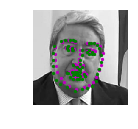

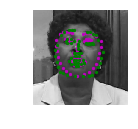

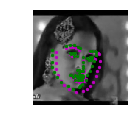

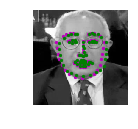

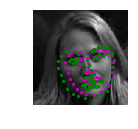

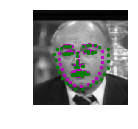

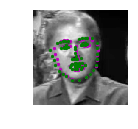

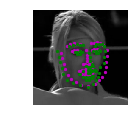

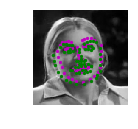

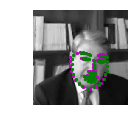

In [29]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I chose to use the following optimizations and loss functions:
   Loss function: nn.SmoothL1Loss(): This was a recommended option from the notebook notes. I also read that this loss function is less sensitive to outliers than MSE according to https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7, which I thought might be helpful. I also tried it and achieved success in combination of my neuronet design and decided to keep it.
    
   Optimizer: Adam: I decided to use Adam because it is a popular and effective optimization algorithm. In this article https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/, and in other deep learning courses I did they recommended adam as the default optimizer. They also used this optimizer in this paper(https://arxiv.org/pdf/1710.00977.pdf)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with a generic structure I used in following along with the class exercises from training the fashion data set classifier. Then I tried to mimic the model referenced in this paper(https://arxiv.org/pdf/1710.00977.pdf) I modified the optimizer and loss function to fit the new problem. 

I decided to add one more convolutional layer as I was using my laptop's gpu and I wanted to throw more brute force at trying out variations in the model. I worried about overfitting with the additional conv layer and used dropout layers with a more aggressive 0.3 as opposed to the standard 0.2. I also added batch normalization to increase the training speed as was done in the referenced paper (https://arxiv.org/pdf/1710.00977.pdf). 

I also realized I needed to not use a relu on the last layer as I was only getting positive numbers out of the model, and this was because of the relu on the last fully connected layer. The predictions were then not appearing in the negative part of the plotted axis.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 
- For number of epochs, I decided to increase the value I was willing to wait through to achieve decent model results. With using the GPU, I ended up finding that 40 epochs ran quickly enough to iterate through a few different configurations.
- For batch size, I knew I wanted to increase it beyond the initial value to give the model more cases for each epoch to train on because it does speed up training and allows for more iterations. I increased the size by 10's, until i arrived at 40. I decided I didt need as much sample in the test case batches and lowered it to half (20). 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.1380799   0.11679539 -0.13740247]
 [-0.21799536 -0.14183481  0.21979772]
 [-0.16948412 -0.05627185 -0.14415395]]
(3, 3)


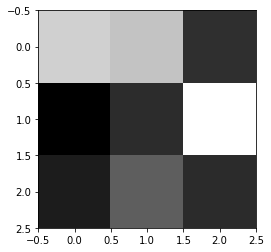

In [34]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

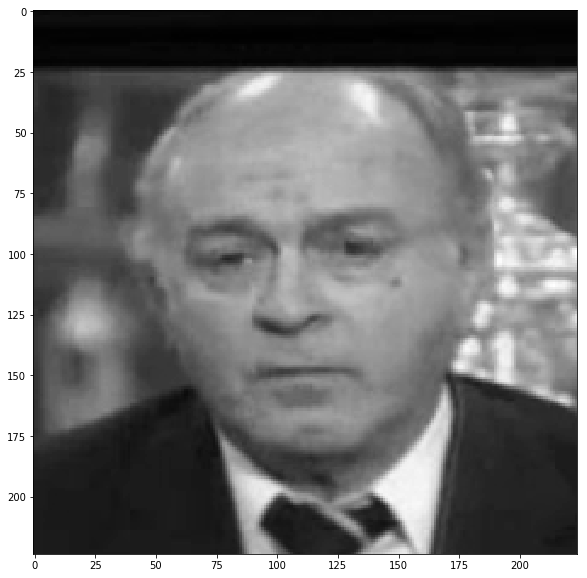

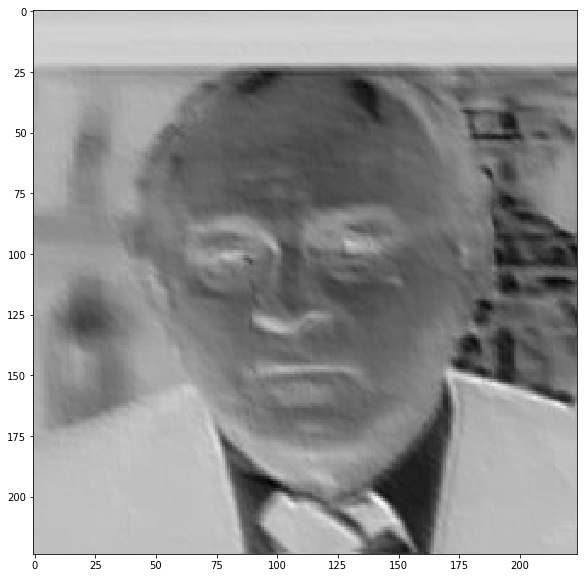

In [35]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
img = test_images[5].data.to('cpu')
img = np.squeeze(img)

import cv2
fig=plt.figure(figsize=(30, 10))
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.to('cpu').numpy()
filt_w = w[2][0]

fig=plt.figure(figsize=(30, 10))

plt.imshow(img, cmap='gray')
c = cv2.filter2D(np.float32(img), -1, filt_w)
plt.imshow(c, cmap='gray')



### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: Looking at the filter I explored above, it seems like it may detect dark areas in the image. The man's darker hair, eyebrows, lips, and dark suit are standing out. The black background brick was also picked up by this filter. Conversely, his lighter skin and light shirt are dark in this filter. This is a darkness filter.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!